## Using Transfer Learning to classify satellite images
Now, let's see transfer learning in practice by trying to classify satellite images.

The dataset used was originally found on kaggle, at this link: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification.

The dataset was then divided into the three partitions: training, validation, and test, each respectively of 60%, 20%, 20% of original dataset.

In [1]:
from keras.layers import Dropout, GlobalAveragePooling2D, Dense
from keras.applications.resnet50 import ResNet50
from keras.utils import image_dataset_from_directory
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [2]:
_URL = 'https://storage.googleapis.com/data_web_mining/dataset.zip'
path_to_zip = tf.keras.utils.get_file('dataset.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'dataset')

25329420/25329420 [==============================] - 1s 0us/step


Let's generate the three subset object, namely: training, validation, and test sets.

In [3]:
train_dataset = image_dataset_from_directory(f'{PATH}/train',
                                             batch_size=BATCH_SIZE,
                                             shuffle = True,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(f'{PATH}/val',
                                             batch_size=BATCH_SIZE,
                                             shuffle = False,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(f'{PATH}/test',
                                             batch_size=BATCH_SIZE,
                                             shuffle = False,
                                             image_size=IMG_SIZE)

Found 3378 files belonging to 4 classes.
Found 1126 files belonging to 4 classes.
Found 1127 files belonging to 4 classes.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)

print(class_names)

['cloudy', 'desert', 'green_area', 'water']


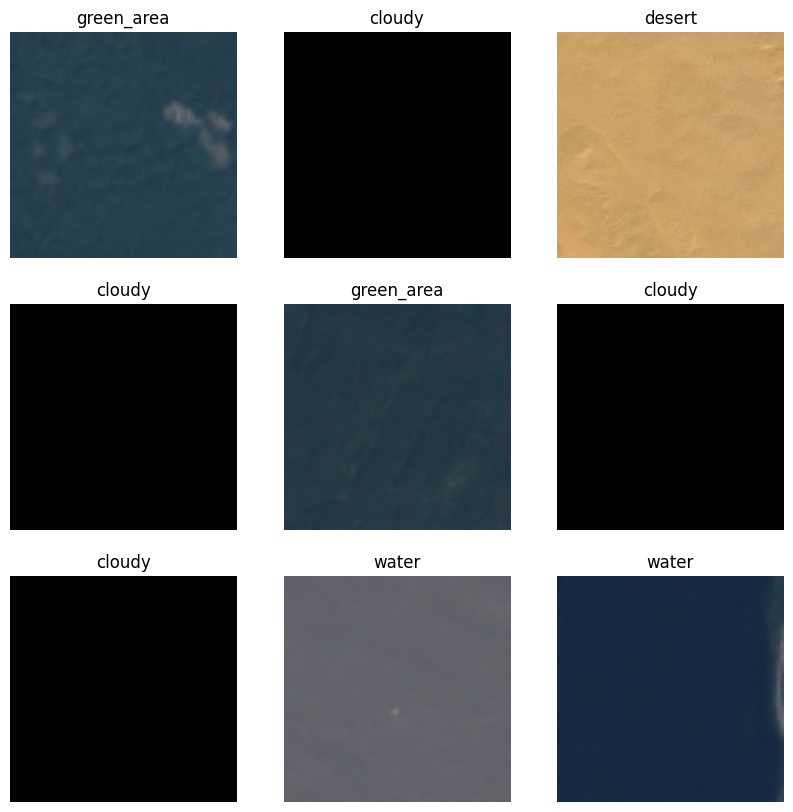

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Let's start to prepare the model. Add various levels of augumentation to improve training and reduce the possibility of overfitting:
- **RandomFlip**: Performs a horizontal or vertical flip of the image with a random probability
- **RandomRotation**: Performs a random rotation of the image with a maximum angle of 0.3 radians
- **RandomZoom**: Applies a random zoom with a maximum value of 30%.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.3)
])

The pre-trained model expects the input data in a certain form, let's rescale it using the method provided directly by ResNet50.

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

Now let's create the base model from the ResNet50. This is pre-trained on the ImageNet dataset.

It's important to freeze all the base model's layers, in order to prevent the weights in a given layer from being updated during training.

In [8]:
base_model = ResNet50(include_top=False, input_shape=IMG_SHAPE, weights='imagenet')
base_model.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


Build our model by chaining together the **data augumentation**, **preprocess input layer**, **base model**, some **convolutional layers**.

In addition, we added a **Dropout** layer that randomly sets input units to 0 with a frequency of 20%

In [9]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [10]:
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=optimizers.Adam(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [12]:
report = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=6,
    callbacks=EarlyStopping(monitor='val_loss', patience=2)
)

Epoch 1/6
106/106 [==============================] - 21s 92ms/step - loss: 1.0578 - accuracy: 0.5796 - val_loss: 0.5579 - val_accuracy: 0.9067
Epoch 2/6
106/106 [==============================] - 8s 69ms/step - loss: 0.4277 - accuracy: 0.9115 - val_loss: 0.2622 - val_accuracy: 0.9813
Epoch 3/6
106/106 [==============================] - 8s 72ms/step - loss: 0.2399 - accuracy: 0.9606 - val_loss: 0.1598 - val_accuracy: 0.9929
Epoch 4/6
106/106 [==============================] - 7s 60ms/step - loss: 0.1601 - accuracy: 0.9799 - val_loss: 0.1106 - val_accuracy: 0.9938
Epoch 5/6
106/106 [==============================] - 8s 70ms/step - loss: 0.1165 - accuracy: 0.9867 - val_loss: 0.0836 - val_accuracy: 0.9938
Epoch 6/6
106/106 [==============================] - 6s 58ms/step - loss: 0.0968 - accuracy: 0.9867 - val_loss: 0.0664 - val_accuracy: 0.9964


In [13]:
val_loss, val_accuracy = model.evaluate(validation_dataset)

36/36 [==============================] - 2s 40ms/step - loss: 0.0664 - accuracy: 0.9964


In [14]:
print(f'Test accuracy: {val_accuracy}')
print(f'Test loss: {val_loss}')

Test accuracy: 0.9964476227760315
Test loss: 0.06641080230474472


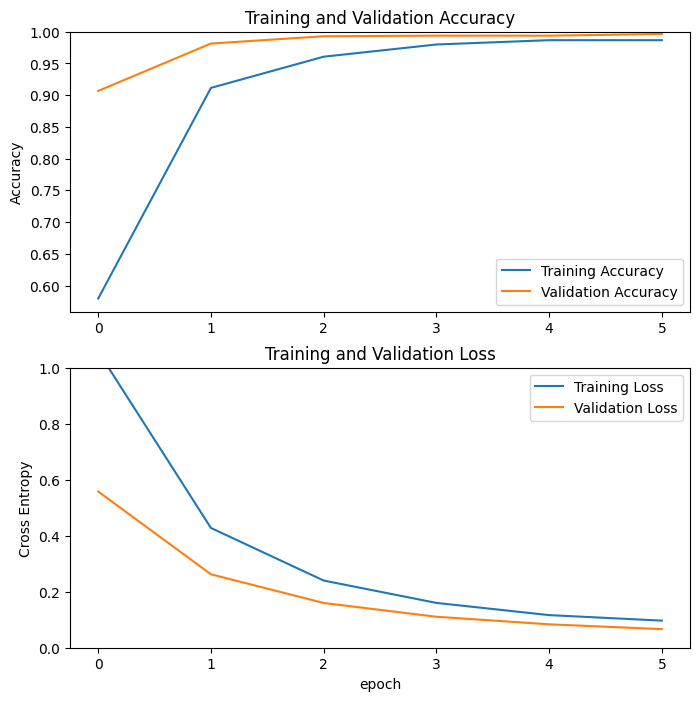

In [15]:
acc = report.history['accuracy']
val_acc = report.history['val_accuracy']

loss = report.history['loss']
val_loss = report.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

With the following line of code, we can extract all the labels of test_dataset

In [16]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

Now that we have extract all the labels, we can build our confusion matrix as follows

36/36 [==============================] - 3s 51ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       227
           2       0.97      1.00      0.98       300
           3       1.00      0.97      0.98       300

    accuracy                           0.99      1127
   macro avg       0.99      0.99      0.99      1127
weighted avg       0.99      0.99      0.99      1127



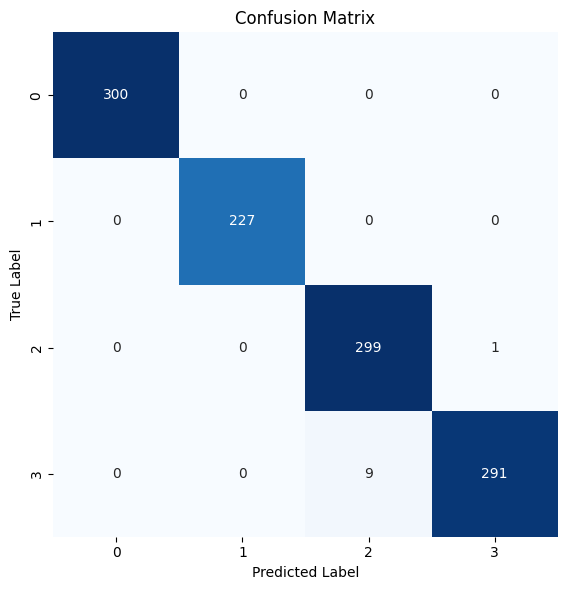

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)


print ("Classification Report")
print ( classification_report(y_true, y_pred) )

mat = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(figsize=(6,6), tight_layout=True)
sns.heatmap(mat, square=True, annot=True, fmt='d',
            cbar=False, cmap="Blues")

axes.set_xlabel('Predicted Label');
axes.set_ylabel('True Label')
axes.set_title('Confusion Matrix');